In [1]:
##------- 1. Load libraries & model
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment


# Step 1: Preprocessing and TF-IDF Vectorization

In [3]:
#load data
df = pd.read_csv("spam.csv")
#show basic information like the nb of nulls an type of data
print(df.info())
df['cleaned_text']=df['text'].apply(clean_text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   target  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [4]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation and special chars (keep apostrophes for words like "don't")
    text = re.sub(r'[^\w\s\']', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [5]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (5572, 5000)


# Step 2: Dimensionality Reduction with PCA

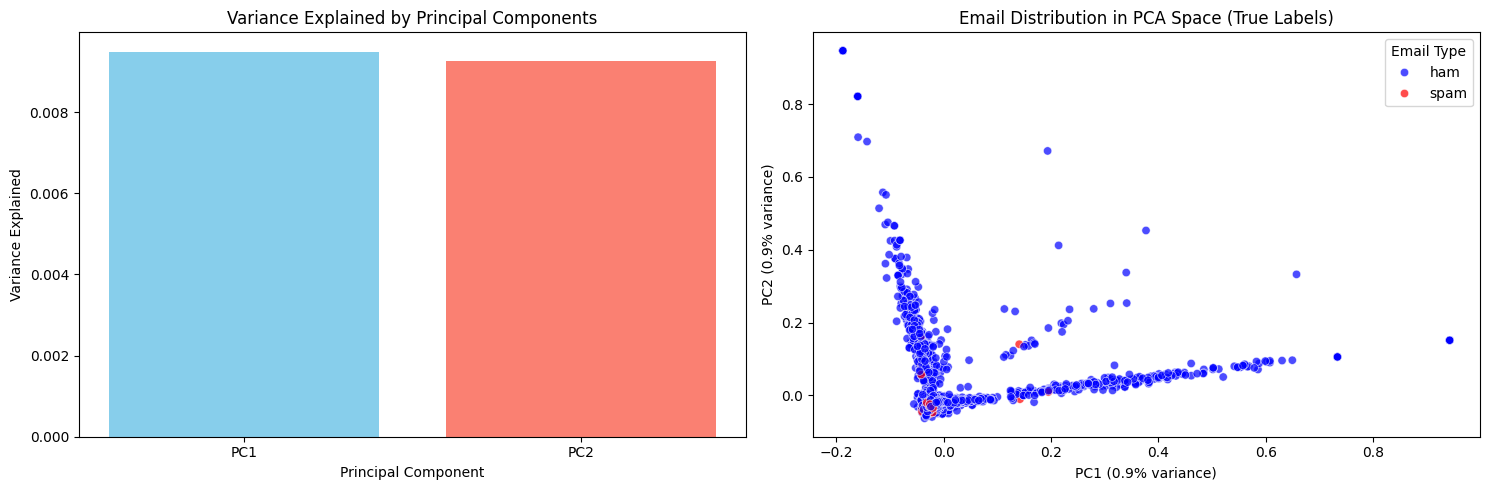

In [13]:
# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create a DataFrame with PCA results and target labels
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = df['target'].values  # Add original labels

# Plot 1: Variance Explained
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(2), pca.explained_variance_ratio_, color=['skyblue', 'salmon'])
plt.title('Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks([0, 1], ['PC1', 'PC2'])

# Plot 2: PCA Space with True Labels
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, 
                palette={'ham': 'blue', 'spam': 'red'}, alpha=0.7)
plt.title('Email Distribution in PCA Space (True Labels)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Email Type')

plt.tight_layout()
plt.show()

# Step 3: Clustering Methods

## K-means Clustering

C:\Users\user\AppData\Local\Programs\Python_\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means Silhouette Score (without PCA): 0.007


C:\Users\user\AppData\Local\Programs\Python_\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


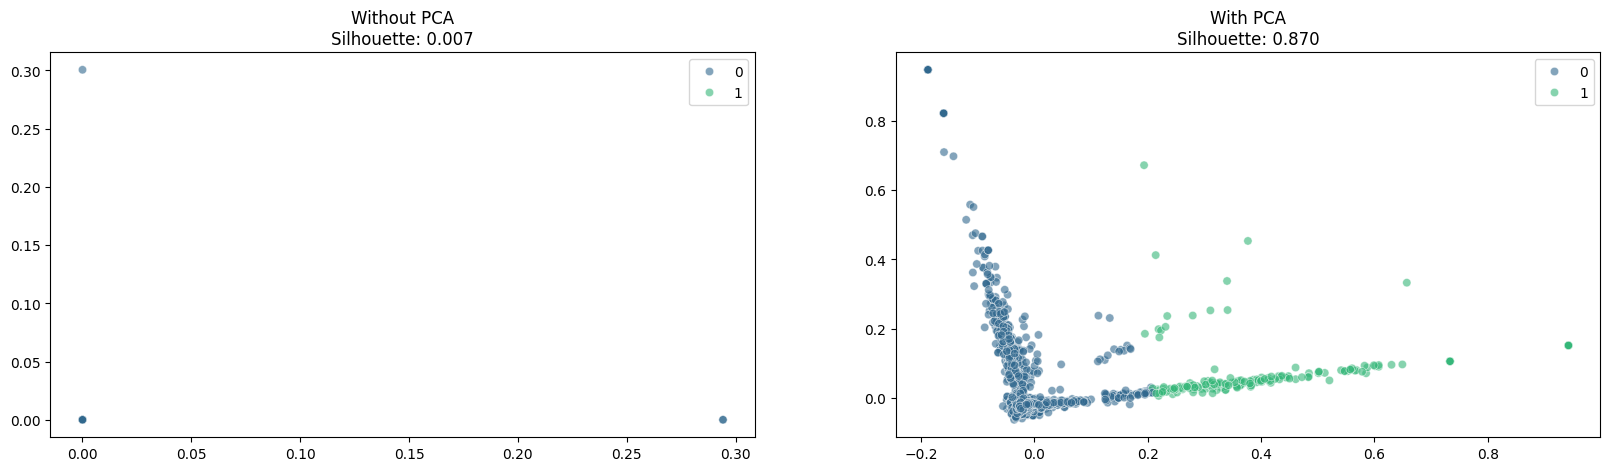

In [40]:
# K-means without PCA
kmeans = KMeans(n_clusters=2, random_state=42)
k_clusters = kmeans.fit_predict(X_tfidf)

# Evaluate
silhouette = silhouette_score(X_tfidf, k_clusters)
print(f"K-means Silhouette Score (without PCA): {silhouette:.3f}")

# K-means with PCA
kmeans_pca = KMeans(n_clusters=2, random_state=42)
k_clusters_pca = kmeans_pca.fit_predict(X_pca)
silhouette_pca = silhouette_score(X_pca, k_clusters_pca)

plt.figure(figsize=(20, 5))
# Plot 1: Without PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tfidf[:, 0].toarray().ravel(), 
                y=X_tfidf[:, 1].toarray().ravel(), 
                hue=k_clusters, palette='viridis', alpha=0.6)
plt.title(f'Without PCA\nSilhouette: {silhouette:.3f}')

# Plot 2: With PCA
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=k_clusters_pca, palette='viridis', alpha=0.6)
plt.title(f'With PCA\nSilhouette: {silhouette_pca:.3f}')
plt.show()

## Hierarchical Clustering

Hierarchical Silhouette Score (without PCA): 0.005


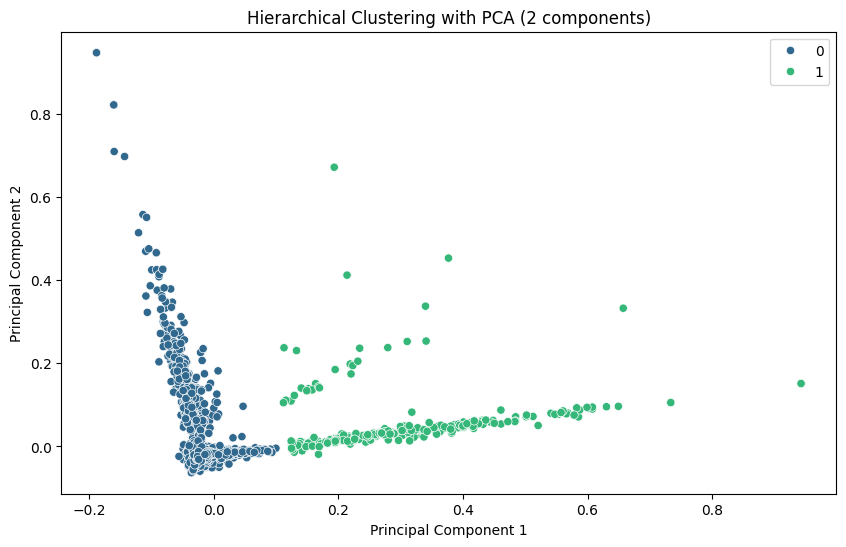

In [8]:
# Hierarchical clustering without PCA
hierarchical = AgglomerativeClustering(n_clusters=2)
h_clusters = hierarchical.fit_predict(X_tfidf.toarray())

# Evaluate
h_silhouette = silhouette_score(X_tfidf, h_clusters)
print(f"Hierarchical Silhouette Score (without PCA): {h_silhouette:.3f}")

# Hierarchical clustering with PCA
hierarchical_pca = AgglomerativeClustering(n_clusters=2)
h_clusters_pca = hierarchical_pca.fit_predict(X_pca)

# Plot Hierarchical with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=h_clusters_pca, palette='viridis')
plt.title('Hierarchical Clustering with PCA (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## DBSCAN Clustering

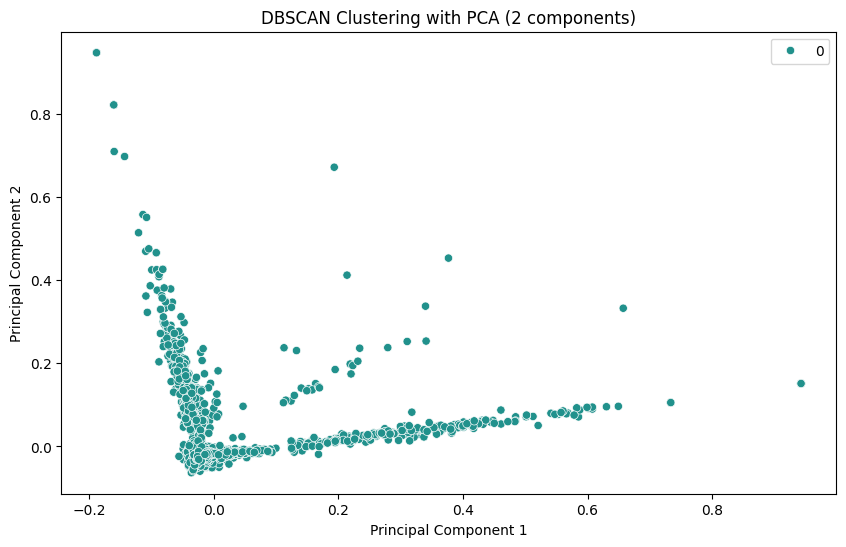

DBSCAN cluster distribution:
0    5572
Name: count, dtype: int64


In [9]:
# DBSCAN with PCA (works better with reduced dimensions)
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_clusters = dbscan.fit_predict(X_pca)

# Plot DBSCAN results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_clusters, palette='viridis')
plt.title('DBSCAN Clustering with PCA (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Count clusters (including noise points marked as -1)
print("DBSCAN cluster distribution:")
print(pd.Series(db_clusters).value_counts())

# Step 4: Compare with Actual Labels

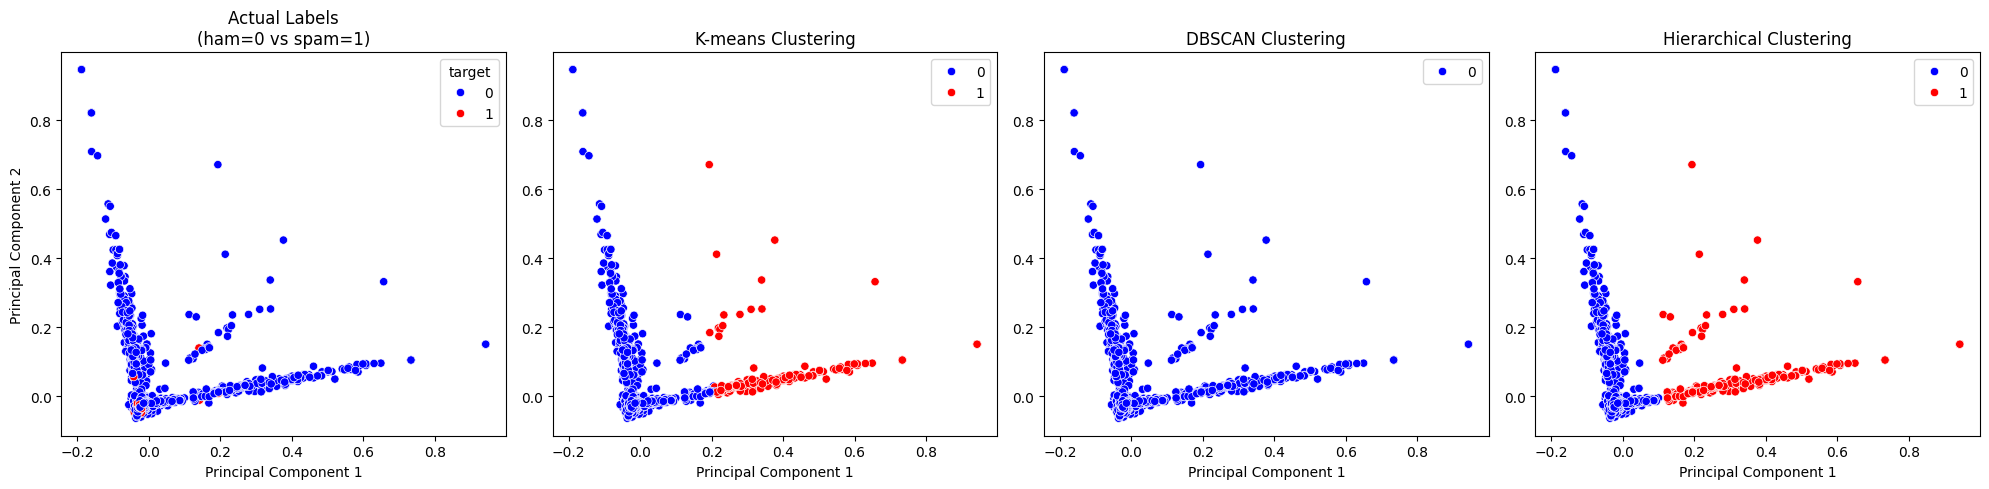

In [37]:
# Define a consistent color palette (0=ham=blue, 1=spam=red)
palette = {0: 'blue', 1: 'red'}

# Create figure with 4 subplots of equal size
plt.figure(figsize=(20, 5))

# 1. Actual Labels
plt.subplot(1, 4, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=df['target'].map({'ham': 0, 'spam': 1}), 
                palette=palette)
plt.title('Actual Labels\n(ham=0 vs spam=1)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 2. K-means Clustering
plt.subplot(1, 4, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=k_clusters_pca_aligned, 
                palette=palette)
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')

# 3. DBSCAN Clustering
plt.subplot(1, 4, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=db_clusters_pca_aligned, 
                palette=palette)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')

# 4. Hierarchical Clustering
plt.subplot(1, 4, 4)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=h_clusters_pca_aligned, 
                palette=palette)
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')

plt.tight_layout()
plt.show()

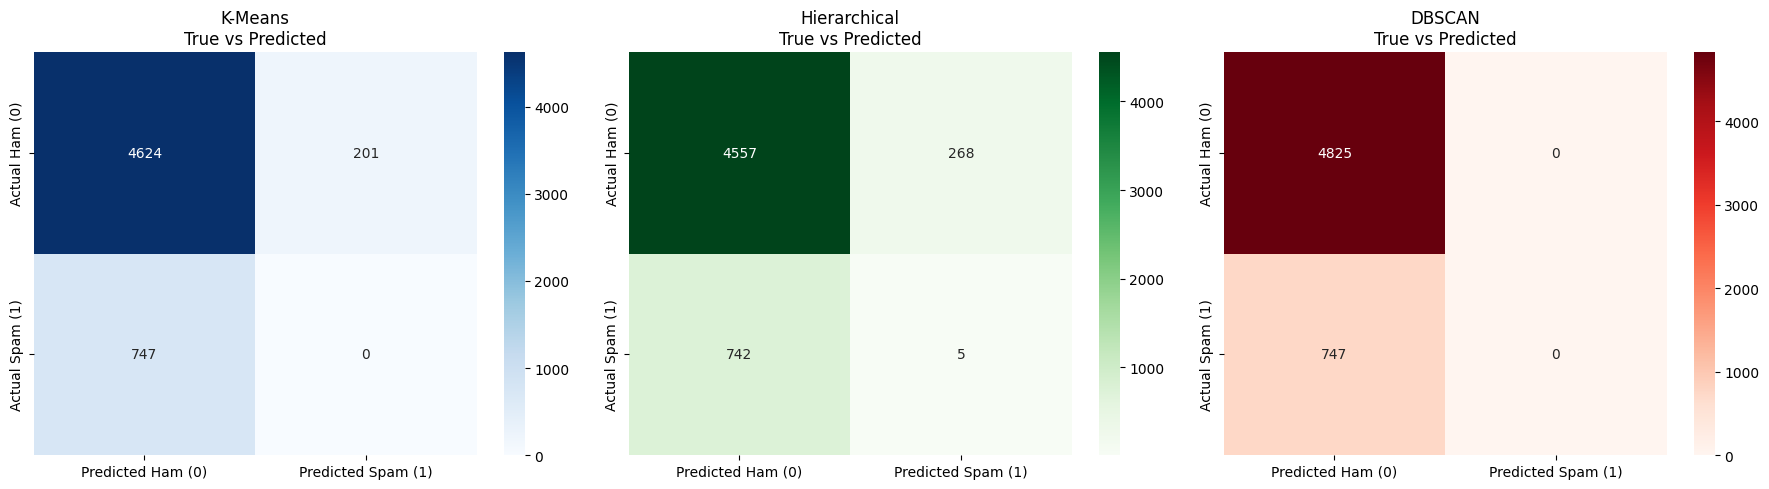

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Adjust cluster labels to match true labels
def align_clusters(true_labels, pred_labels):
    if np.mean(pred_labels == true_labels) < 0.5:
        return 1 - pred_labels
    return pred_labels

# Align both clustering results
k_clusters_pca_aligned = align_clusters(true_labels, k_clusters_pca)
h_clusters_pca_aligned = align_clusters(true_labels, h_clusters_pca)
db_clusters_pca_aligned = align_clusters(true_labels, db_clusters)



# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. K-Means Clustering
kmeans_cm = confusion_matrix(true_labels, k_clusters_pca_aligned)
sns.heatmap(kmeans_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'],
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
ax1.set_title('K-Means\nTrue vs Predicted')

# 2. Hierarchical Clustering
hierarchical_cm = confusion_matrix(true_labels, h_clusters_pca_aligned)
sns.heatmap(hierarchical_cm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'],
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
ax2.set_title('Hierarchical\nTrue vs Predicted')

# 3. DBSCAN Clustering
dbscan_cm = confusion_matrix(true_labels, db_clusters_pca_aligned)
sns.heatmap(dbscan_cm, annot=True, fmt='d', cmap='Reds', ax=ax3,
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'],
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
ax3.set_title('DBSCAN\nTrue vs Predicted')

plt.tight_layout()
plt.show()